# Make linear models regressing to OGTT AUC using only TGs

## Katie's idea was to see if summed TG quants can correlate with OGTT. 
### If they do, then the Wako trigylceride assay (https://us.vwr.com/store/product/18367215/l-type-triglyceride-m-assay-wako) would find similar information, and the assay could serve as a rapid indicator of a rat's diabetic status at a young age

### Make 4 pairs of models (fasted vs fed for all): 
1. TGs from all random-fed versus all fasted data, averaged within itself
2. All TGs averaged from week 8 
3. Week 9
4. Week 10

### Compare these models to only the top 10 "best" TGs (maybe the highly polyunsaturated TGs will be best)

In [1]:
import time
from collections import defaultdict
import json
import math

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search
from src.plot import plot_quant_vs_ogtt
from src.parse_lipid import parse_lipid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [8]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
# data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data = pd.read_csv(r'../data/processed/combined_metabolites_data.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

X_all = data[data_cols].T

# X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

### Compare top 10 TGs based on:
1. r2 * coef of linear model on random-fed data
2. q-value of OGTT 

In [3]:
display(data.loc[data['molec_class'] == 'TG'].sort_values('qval_fed').iloc[:10]['ID'])
data.loc[data['molec_class'] == 'TG'].sort_values('qval_ogtt').iloc[:10]['ID']

i
l_538    TG 22:6_22:6_22:6
l_567    TG 18:2_22:6_22:6
l_579             TG 62:13
l_604    TG 18:1_22:6_22:6
l_672             TG 60:10
l_525    TG 20:5_22:6_22:6
l_619    TG 16:0_22:6_22:5
l_636    TG 18:0_20:5_22:6
l_559             TG 60:13
l_608    TG 16:0_22:6_22:6
Name: ID, dtype: object

i
l_538    TG 22:6_22:6_22:6
l_567    TG 18:2_22:6_22:6
l_672             TG 60:10
l_579             TG 62:13
l_619    TG 16:0_22:6_22:5
l_608    TG 16:0_22:6_22:6
l_604    TG 18:1_22:6_22:6
l_525    TG 20:5_22:6_22:6
l_636    TG 18:0_20:5_22:6
l_600    TG 18:2_18:2_22:6
Name: ID, dtype: object

# To use `plot_quant_vs_ogtt` for means of TGs, an extra row has to be made and appended to `data`
## `include_info=True` cannot be used, because there are no p-values for this new row

In [9]:
data['fa_carbons'] = data['ID'].apply((lambda lipid: parse_lipid(lipid)[2]))
data['fa_unsat']   = data['ID'].apply((lambda lipid: parse_lipid(lipid)[3]))

# Get average of all TGs
data.loc['All TGs', data_cols] = data.loc[data['molec_class'] == 'TG', data_cols].mean()

# Get average of all TGs within a certain number of unsaturations
for unsat_count, unsat_start, unsat_stop in [
    ('0-2 unsaturations', 0, 3),
    ('3-5 unsaturations', 3, 6),
    ('6-9 unsaturations', 6, 10),
    ('10-18 unsaturations', 10, 999)]:
    
    subset = data.loc[(data['fa_unsat'] >= unsat_start) & (data['fa_unsat'] < unsat_stop), data_cols].mean()
    data.loc[unsat_count, data_cols] = subset
data

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,qval_fed,qval_fasted,pval_fed,pval_fasted,fa_carbons,fa_unsat
i,,,,,,,,,,,,,,,,,,,,,
m_0,unknown_2.353_141.06591,2.353,141.06591,[M-H]-1,metabolite,-,unknown,16.861652,16.671317,17.594730,...,0.631782,5.498881e-01,0.000028,0.520258,0.005399,0.043385,1.774542e-03,0.005889,NaN,NaN
m_1,unknown_11.539_180.0585,11.539,180.05850,[M-H]-1,metabolite,-,unknown,22.144573,20.963399,20.198771,...,0.000126,6.116236e-11,0.000611,0.000003,0.000001,0.554565,3.159016e-08,0.337609,NaN,NaN
m_2,Urocanic acid_11.365_139.05028,11.365,139.05028,[M+H]+1,metabolite,+,Urocanic acid,22.576981,23.843259,23.895235,...,0.685202,1.412000e-01,0.534845,0.582536,0.563218,0.982152,4.526725e-01,0.955407,NaN,NaN
m_3,Uridine_7.513_243.06152,7.513,243.06152,[M-H]-1,metabolite,-,Uridine,23.803795,24.316310,24.714910,...,0.537969,2.563897e-11,0.040026,0.416631,0.531078,0.111421,4.126169e-01,0.029282,NaN,NaN
m_4,Uric acid_12.732_167.02007,12.732,167.02007,[M-H]-1,metabolite,-,Uric acid,24.596731,26.201371,17.148994,...,0.259251,3.452344e-01,0.016251,0.151978,0.562464,0.069633,4.510871e-01,0.013072,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
All TGs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.842725,23.442414,23.919615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0-2 unsaturations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.702575,23.576125,22.676202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3-5 unsaturations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.561829,23.056133,22.331303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TG 22:6_22:6_22:6 is not the best TG because it has such a low quant in normal rats (around log2 quant = 15)
## TG 18:2_22:6_22:6 is better because it starts around 19. 

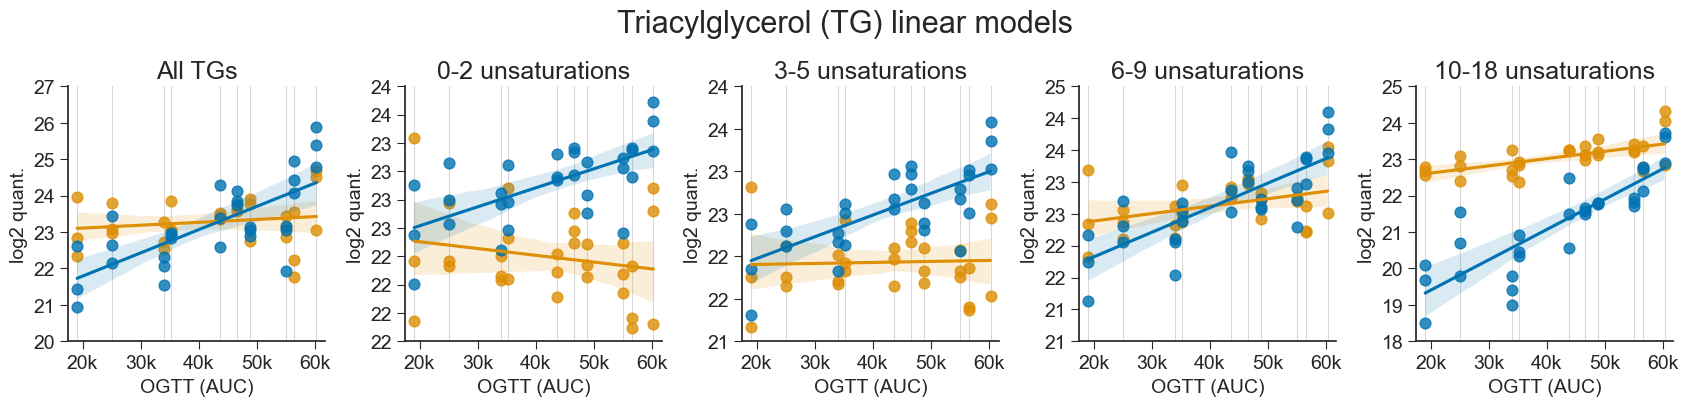

In [13]:
subsets_titles = data.loc['All TGs':'10-18 unsaturations'].index
#     (tg10, 'Mean of Top 10 TGs\n(by p-value signif.)'),
#     (tg_saturated, 'Mean of\nsaturated TGs'),
#     (tg_monounsat, 'Mean of\nmonounsaturated TGs'),
#     (tg_2_to_9_unsat, 'Mean of TGs\nbetween 2 and 9 unsat.'),
#     (tg_very_unsat, 'Mean of TGs with\ntotal unsat. > 9'),
#     (tg1, f'Top TG\n({top_tg_id})'),


weeks = [([8, 9, 10], 'All 3\nweeks'),] #  ([8], 'Week 8'), ([9], 'Week 9'), ([10], 'Week 10'),]

nrows = len(weeks)
ncols = len(subsets_titles)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='col', 
                        figsize=(3*ncols+2, 2.1*nrows+2), facecolor='white', dpi=100)
if nrows == 1:
    axs = [axs, ]
if ncols == 1:
    axs = [[ax, ] for ax in axs]
fig.suptitle('Triacylglycerol (TG) linear models', fontsize=22)
# fig.supxlabel('OGTT (AUC)', fontsize=20)
# fig.supylabel('Using\ndata\nfrom', fontsize=20, rotation=0)

for row, (week, week_title) in enumerate(weeks):
    for col, subset in enumerate(subsets_titles):
        ax = axs[row][col]
        plot_quant_vs_ogtt(feature=subset, data=data, ax=ax)
#         if col == 0:
#             ax.set_ylabel(week_title, fontsize=18, rotation=0, ha='right', fontweight='bold')
        if row == 0:
            ax.set_title(subset, fontsize=18)

plt.tight_layout()
plt.savefig('../reports/figures/all_TG_plots/TG_allweeks_unsats.svg', dpi=150, bbox_inches='tight')
plt.savefig('../reports/figures/all_TG_plots/TG_allweeks_unsats.png', dpi=150, bbox_inches='tight')

In [430]:
# top_tg = top10_tg[0]
# top_tg_id = data.loc[top_tg, 'ID']
# tg1 =  data.loc[top_tg, data_cols] \
#            .astype('float') \
#            .to_frame(name='quant') \
#            .join(fg[['bg_type', 'ogtt', 'animal']])

# fig, ((a1, a2, a3), (a4, a5, a6), (a7, a8, a9), (a10, a11, a12)) = plt.subplots(
#     nrows=4, ncols=3, sharex=True, sharey='col', figsize=(14, 11))
# fig.suptitle('Triacylglycerol (TG) linear models', fontsize=22)
# fig.supxlabel('OGTT (AUC)', fontsize=20)
# fig.supylabel('Using\ndata\nfrom', fontsize=20, rotation=0)

# make_regplot(df=tg,                         ax=a1)  # title='Mean all TG',   
# make_regplot(df=tg.loc[fg['week'] == 8],    ax=a4)  # title='Mean all TG',   
# make_regplot(df=tg.loc[fg['week'] == 9],    ax=a7)  # title='Mean all TG',   
# make_regplot(df=tg.loc[fg['week'] == 10],   ax=a10)  # title='Mean all TG',   
# make_regplot(df=tg10,                       ax=a2)  # title='Mean top 10 TG',
# make_regplot(df=tg10.loc[fg['week'] == 8],  ax=a5)  # title='Mean top 10 TG',
# make_regplot(df=tg10.loc[fg['week'] == 9],  ax=a8)  # title='Mean top 10 TG',
# make_regplot(df=tg10.loc[fg['week'] == 10], ax=a11)  # title='Mean top 10 TG',
# make_regplot(df=tg1,                        ax=a3) 
# make_regplot(df=tg1.loc[fg['week'] == 8],   ax=a6) 
# make_regplot(df=tg1.loc[fg['week'] == 9],   ax=a9) 
# make_regplot(df=tg1.loc[fg['week'] == 10],  ax=a12)

# for ax, week in zip([a1, a4, a7, a10], ['All\nweeks', 'Week 8', 'Week 9', 'Week 10']):
#     ax.set_ylabel(week, fontsize=18, rotation=0, ha='right', fontweight='bold')
# a1.set_title('Mean of all TGs', fontsize=18)
# a2.set_title('Mean of Top 10 TGs', fontsize=18)
# a3.set_title(f'Top TG\n({top_tg_id})', fontsize=18)

# plt.tight_layout()

# plt.savefig('../reports/figures/TG_linear_models/TG_asdf.png', dpi=100, facecolor='white', bbox_inches='tight')

In [664]:
# all_tgs = data.loc[data['molec_class'] == 'TG'].copy()
# all_tgs['fa_carbons'], all_tgs['fa_unsat'], all_tgs['fa_carbon:unsat'] = \
#     zip(*all_tgs.loc[:, 'ID'].apply(lambda x: parse_lipid(x)[2:5]))

# tg = all_tgs.loc[:, data_cols] \
#             .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])
# tg_top10 = all_tgs.sort_values('qval_ogtt').iloc[:10].loc[:, data_cols] \
#                   .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])

# tg_saturated = all_tgs.loc[all_tgs['fa_unsat'] == 0, data_cols] \
#                       .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])
# tg_monounsat = all_tgs.loc[all_tgs['fa_unsat'] == 1, data_cols] \
#                       .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])

# top_tg = all_tgs.sort_values('pval_sampling:ogtt').iloc[0].name
# top_tg_id = data.loc[top_tg, 'ID']
# tg1 =  all_tgs.loc[top_tg, data_cols] \
#               .astype('float').to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])

# tg_very_unsat = all_tgs.loc[all_tgs['fa_unsat'] > 9, data_cols] \
#                        .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])
# tg_2_to_9_unsat = all_tgs.loc[(all_tgs['fa_unsat'] <= 9) & (all_tgs['fa_unsat'] >= 2), data_cols] \
#                        .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])

# unsat_dfs = {}
# for unsat_count, unsat_start, unsat_stop in [
#     ('0-2 unsaturations', 0, 3),
#     ('3-5 unsaturations', 3, 6),
#     ('6-9 unsaturations', 6, 10),
#     ('10-18 unsaturations', 10, 99),
# ]:
#     df = all_tgs.loc[(all_tgs['fa_unsat'] >= unsat_start) & (all_tgs['fa_unsat'] < unsat_stop), data_cols] \
#                 .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])
#     unsat_dfs[unsat_count] = df

# make_regplot(df=tg)